In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import ydata_profiling as yd

C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('datasets\Alcohol_Sales.csv', index_col="DATE", parse_dates=True)

In [3]:
print(df.head())
print(df.info())
print(df.describe())

            S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB
None
       S4248SM144NCEN
count      325.000000
mean      7886.400000
std       2914.269061
min       3031.000000
25%       5231.000000
50%       7481.000000
75%       9977.000000
max      15504.000000


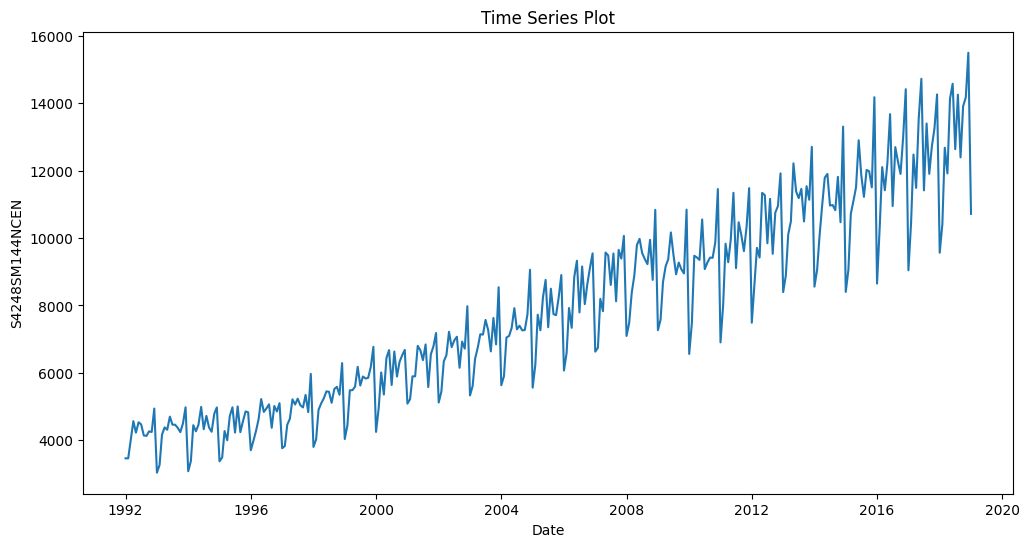

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[df.columns[0]])  # Specify x and y data explicitly
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel(df.columns[0])
plt.show()


In [5]:
DataProfile = yd.ProfileReport(df)
DataProfile.to_file("Profile.json")
DataProfile.to_file("Profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 467.96it/s]


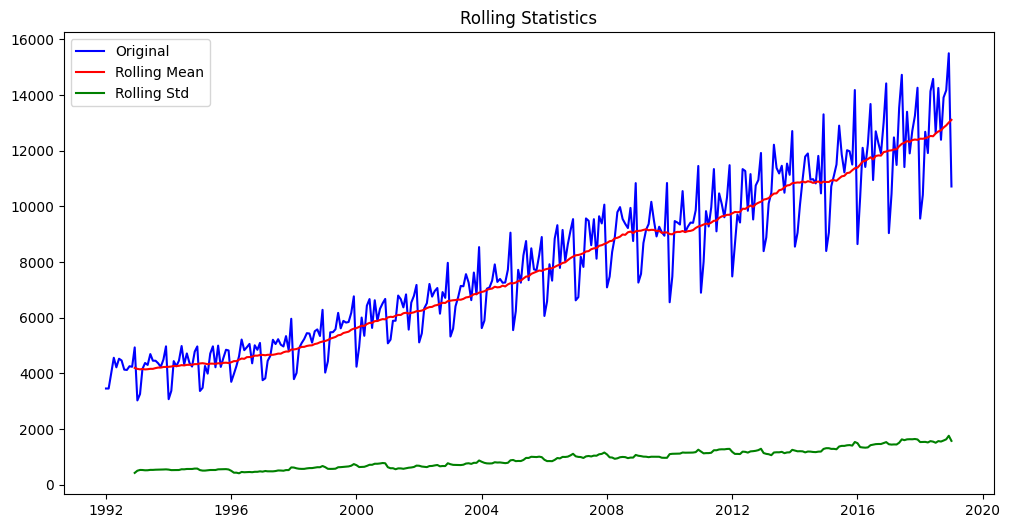

In [6]:
# Convert 'S4248SM144NCEN' column to numeric, handling errors
try:
    df[df.columns[0]] = pd.to_numeric(
        df[df.columns[0]].str.replace("?", ""), errors="coerce"
    )
except:
    pass
finally:
    rolling_mean = df[df.columns[0]].rolling(window=12).mean()
    rolling_std = df[df.columns[0]].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df[df.columns[0]], color="blue", label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Statistics")
plt.show()

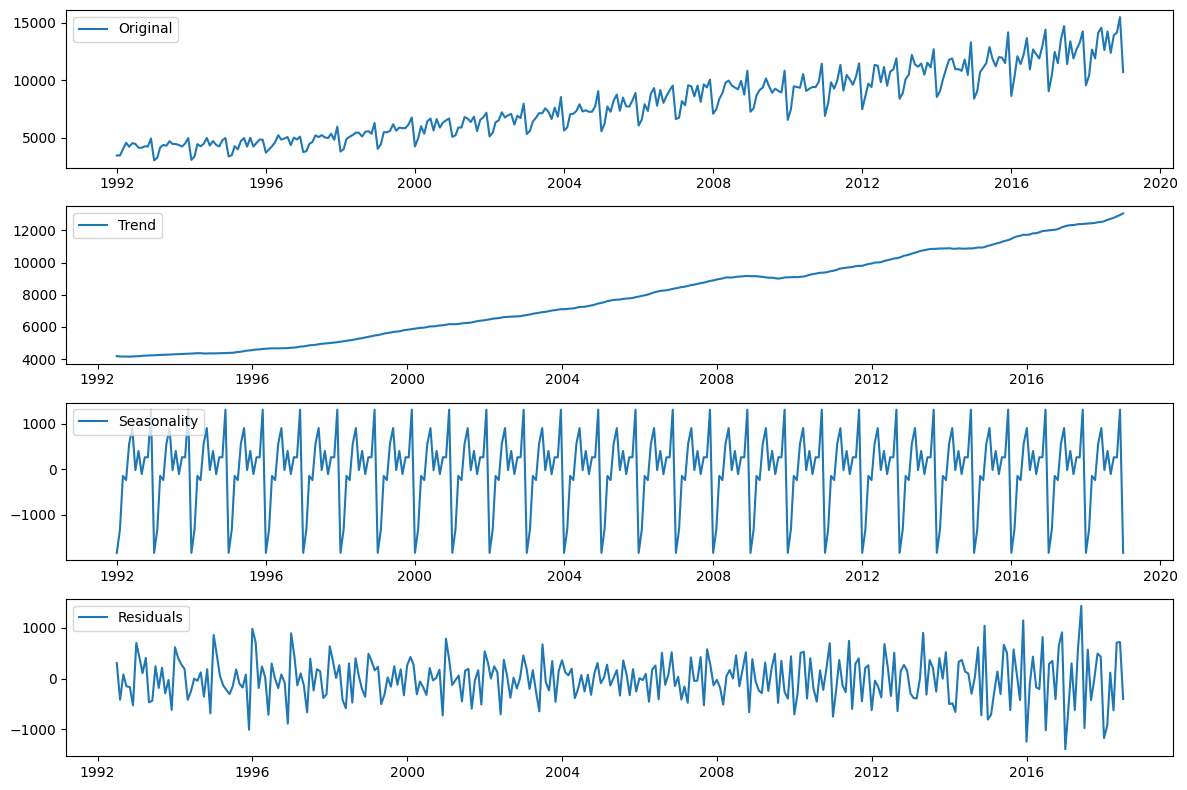

In [7]:
decomposition = seasonal_decompose(df, model='additive', period=12)  # Adjust period as needed

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
# plt.figure(figsize=(12, 8))
# decomposition = seasonal_decompose(df, model='additive', period=12)  # Adjust period as needed
# decomposition.plot()
# plt.show()

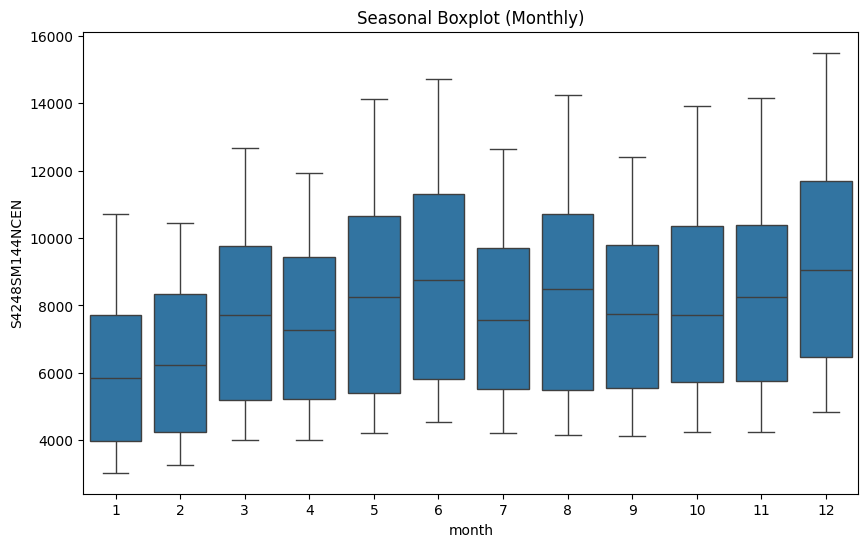

In [9]:
df["month"] = df.index.month
fig, ax = plt.subplots(figsize=(10, 6))
# Use 'S4248SM144NCEN' instead of 'Value' for the y-axis
sns.boxplot(x="month", y=df.columns[0], data=df, ax=ax)
ax.set_title("Seasonal Boxplot (Monthly)")
plt.show()

<Figure size 1800x1200 with 0 Axes>

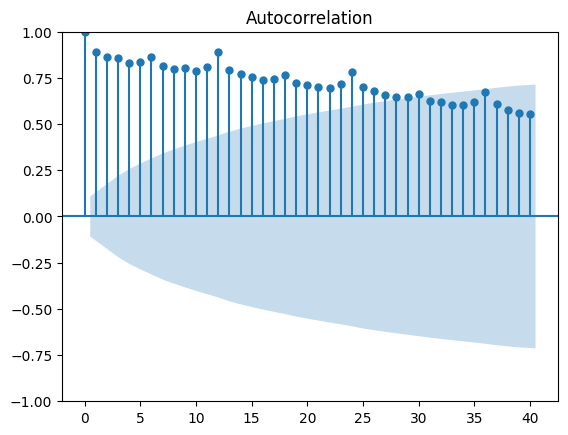

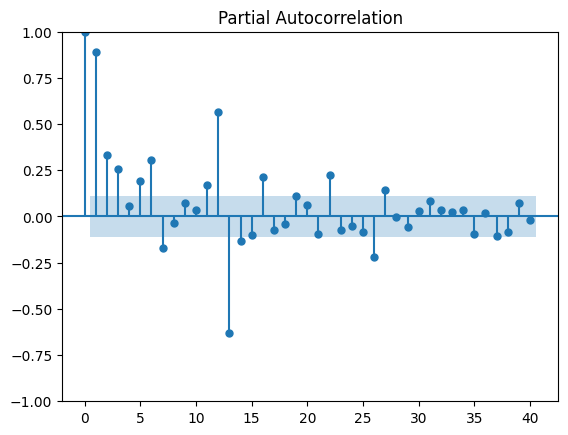

In [10]:
plt.figure(figsize=(18, 12))
# plt.subplot(121)
# Select the 'S4248SM144NCEN' column for ACF plot
plot_acf(df[df.columns[0]], lags=40)
# plt.subplot(122)
# Select the 'S4248SM144NCEN' column for PACF plot
plot_pacf(df[df.columns[0]], lags=40)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   2.037405
p-value                          0.998720
#Lags Used                      14.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64
Conclusion: Series is now likely non-stationary.
Results of Dickey-Fuller Test:
Test Statistic                  -4.365960
p-value                          0.000341
#Lags Used                      13.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64
Conclusion: Series is likely stationary.


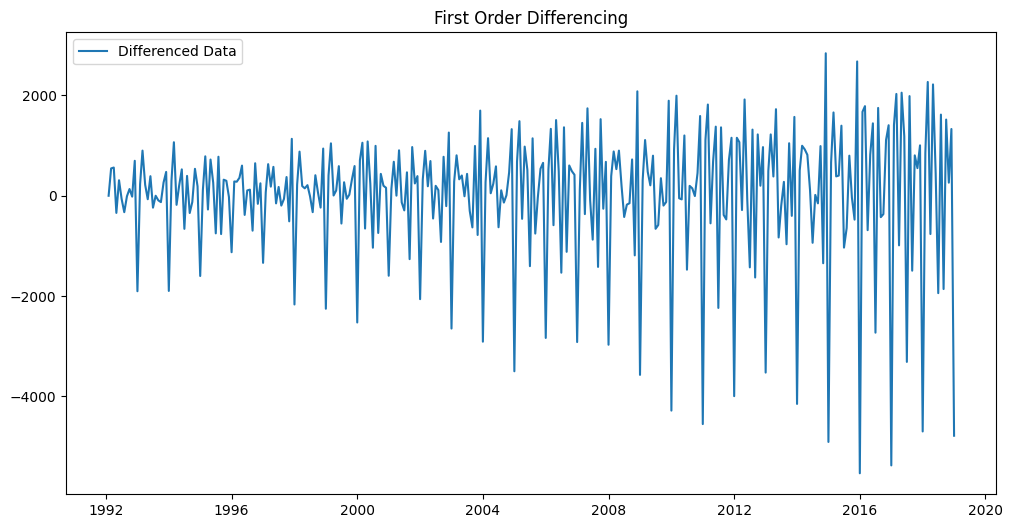

In [11]:
def stationarity_test(timeseries):
    """
    Performs the Dickey-Fuller test to check for stationarity.

    Args:
      timeseries: The time series data.

    Returns:
      A tuple containing the test statistic, p-value, lags used,
      number of observations used, critical values, and the
      results of the test (whether the series is stationary or not).
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion: Series is likely stationary.")
    else:
        print("Conclusion: Series is now likely non-stationary.")
        # %%
        # Differencing to achieve stationarity
        # Change 'Value' to 'S4248SM144NCEN'
        df['Value_diff'] = df[df.columns[0]].diff().dropna()
        stationarity_test(df['Value_diff'].dropna())

        plt.figure(figsize=(12,6))
        plt.plot(df['Value_diff'], label='Differenced Data')
        plt.title('First Order Differencing')
        plt.legend()
        plt.show()

# Change 'Value' to 'S4248SM144NCEN' when calling the function
stationarity_test(df[df.columns[0]])